In [6]:
device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [7]:
from pathlib import Path

# base path to your project
base = Path("ML Projects/Face Mask Detection")

# define subdirectories
subdirs = [
    "data/raw/images",
    "data/raw/annotations",
    "data/processed",
    "notebooks",
    "outputs"
]

for sd in subdirs:
    (base / sd).mkdir(parents=True, exist_ok=True)

print("Directory structure created under:", base.resolve())


Directory structure created under: /Users/lornaolum/ML Projects/Face Mask Detection/ML Projects/Face Mask Detection


In [8]:
from pathlib import Path

# project root
project_root = Path("mask_detection_project")

# subfolders
subdirs = ["images", "annotations", "data", "notebooks", "outputs"]

for sd in subdirs:
    (project_root / sd).mkdir(parents=True, exist_ok=True)

print("Project structure created at:", project_root.resolve())


Project structure created at: /Users/lornaolum/ML Projects/Face Mask Detection/mask_detection_project


In [9]:
from pathlib import Path

base = Path("data")

images_path = base / "images"
annotations_path = base / "annotations"

png_files = list(images_path.glob("*.png"))
xml_files = list(annotations_path.glob("*.xml"))

print("Number of PNG images:", len(png_files))
print("Number of XML annotations:", len(xml_files))

# Show a few examples
print("\nSample images:", [f.name for f in png_files[:3]])
print("Sample annotations:", [f.name for f in xml_files[:3]])



Number of PNG images: 853
Number of XML annotations: 853

Sample images: ['maksssksksss702.png', 'maksssksksss716.png', 'maksssksksss299.png']
Sample annotations: ['maksssksksss299.xml', 'maksssksksss528.xml', 'maksssksksss272.xml']


In [10]:
#Check that every image has a matching annotation

In [11]:
# check consistency between images and annotations
image_stems = {f.stem for f in png_files}
xml_stems = {f.stem for f in xml_files}

only_images = image_stems - xml_stems
only_xmls = xml_stems - image_stems

print("Matching pairs:", len(image_stems & xml_stems))
print("Images without XML:", len(only_images))
print("XML without Images:", len(only_xmls))

# show a few mismatches (if any)
print("Images missing XML:", list(only_images)[:5])
print("XMLs missing Image:", list(only_xmls)[:5])


Matching pairs: 853
Images without XML: 0
XML without Images: 0
Images missing XML: []
XMLs missing Image: []


In [12]:
#Visualize images + bounding boxes

<annotation>
    <folder>images</folder>
    <filename>maksssksksss702.png</filename>
    <size>
        <width>600</width>
        <height>317</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>9</xmin>
            <ymin>170</ymin>
            <xmax>60</xmax>
            <ymax>229</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>165</xmin>
            <ymin>90</ymin>
            <xmax>202</xmax>
            <ymax>124</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncate

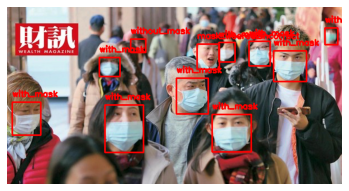

In [13]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

# pick one sample
sample_img = png_files[0]
sample_xml = annotations_path / (sample_img.stem + ".xml")

# parse the XML
tree = ET.parse(sample_xml)
root = tree.getroot()

# read image
img = cv2.imread(str(sample_img))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(ET.tostring(root, encoding="unicode"))

# loop through objects in XML
for obj in root.findall("object"):
    label = obj.find("name").text
    bbox = obj.find("bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)

    # draw rectangle + label
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.putText(img, label, (xmin, ymin-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

# show
plt.imshow(img)
plt.axis("off")
plt.show()


In [21]:
import os
import shutil
import random
from pathlib import Path
import xml.etree.ElementTree as ET
from torchvision import transforms


# Base folder
base = Path("data")

# Original images and annotations
img_folder = base / "images"
ann_folder = base / "annotations"

images = list(img_folder.glob("*.png"))
annotations = list(ann_folder.glob("*.xml"))

# pair images and XMLs
data = list(zip(sorted(images), sorted(annotations)))
random.seed(42)
random.shuffle(data)

# split fractions
n = len(data)
splits = {
    "train": data[:int(0.8*n)],
    "val": data[int(0.8*n):int(0.9*n)],
    "test": data[int(0.9*n):]
}

# create folders and move images
for split_name, split_data in splits.items():
    for img, ann in split_data:
        # get class from first object in XML
        tree = ET.parse(ann)
        root = tree.getroot()
        class_name = root.find("object").find("name").text

        # image class folder
        class_folder = base / split_name / "images" / class_name
        class_folder.mkdir(parents=True, exist_ok=True)

        # annotation folder
        ann_split_folder = base / split_name / "annotations"
        ann_split_folder.mkdir(parents=True, exist_ok=True)

        # copy image and annotation
        shutil.copy(img, class_folder / img.name)
        shutil.copy(ann, ann_split_folder / ann.name)

print("Train/Val/Test folders created and images categorized by class!")


Train/Val/Test folders created and images categorized by class!


In [22]:
import os

train_images = os.path.join(base, "train", "images")
print(os.listdir(train_images))


['mask_weared_incorrect', 'with_mask', 'without_mask']


In [23]:
height = 224
width = 224


class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

print(transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [26]:
from torchvision import datasets, transforms

dataset =  datasets.ImageFolder(root=train_images, transform=transform)

print("Length of dataset:", len(dataset))

Length of dataset: 682


In [27]:
from torch.utils.data import DataLoader, random_split
batch_size = 32

dataset_loader  = DataLoader(dataset, batch_size=batch_size)


batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([32, 3, 224, 224])


In [28]:
mean = 0.
std = 0.
nb_samples = 0

for data, _ in dataset_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4684, 0.4482, 0.4409])
Std: tensor([0.2527, 0.2461, 0.2448])


In [29]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((width, height)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

print(transform_norm)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.4684, 0.4482, 0.4409]), std=tensor([0.2527, 0.2461, 0.2448]))
)


In [31]:
import torch

g = torch.Generator()
g.manual_seed(42)


norm_dataset = datasets.ImageFolder(train_images, transform = transform_norm)
# Important, DON'T change the `generator=g` parameter
#train_dataset, val_dataset = random_split(..., generator=g)
train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2], generator=g)

print("Length of dataset:", len(norm_dataset))
print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

Length of dataset: 682
Training data set size: 546
Validation data set size: 136


In [32]:
# Important! don't change this.
g = torch.Generator()
g.manual_seed(42)

batch_size = 32

# Important! Don't change the `generator=g` parameter
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(type(train_loader))
print(type(val_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [4]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [33]:
from torchinfo import summary
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1_n_kernels = 16
conv1 = torch.nn.Conv2d(
    in_channels=3, out_channels=conv1_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool_size = 4
max_pool1 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2_n_kernels = 32
conv2 = torch.nn.Conv2d(
    in_channels=16, out_channels=conv2_n_kernels, kernel_size=(3, 3), padding=1
)
max_pool2 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3_n_kernels = 64
conv3 = torch.nn.Conv2d(32, conv3_n_kernels, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(max_pool_size)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=576, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

n_classes = 3
output_layer = torch.nn.Linear(500, n_classes)
model.append(output_layer)

summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 3]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
├─Dropout: 1-11                          [32, 576]                 --
├─Linear: 1-12                           [32, 500]                 288,500
├─

In [37]:
import torch.nn as nn
import torch.optim as optim

# loss function
loss_fn = nn.CrossEntropyLoss()
print("Loss function:", loss_fn)

# optimizer
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
print("Optimizer:", optimizer)



Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


Epoch 1/15 - Train Loss: 0.6459, Train Acc: 78.94% - Val Loss: 0.8170, Val Acc: 77.21%
Epoch 2/15 - Train Loss: 0.5809, Train Acc: 81.68% - Val Loss: 0.6850, Val Acc: 77.21%
Epoch 3/15 - Train Loss: 0.5637, Train Acc: 81.68% - Val Loss: 0.6939, Val Acc: 77.21%
Epoch 4/15 - Train Loss: 0.5843, Train Acc: 81.68% - Val Loss: 0.7157, Val Acc: 77.21%
Epoch 5/15 - Train Loss: 0.6014, Train Acc: 81.68% - Val Loss: 0.7186, Val Acc: 77.21%
Epoch 6/15 - Train Loss: 0.5715, Train Acc: 81.68% - Val Loss: 0.6754, Val Acc: 77.21%
Epoch 7/15 - Train Loss: 0.5522, Train Acc: 81.68% - Val Loss: 0.6703, Val Acc: 77.21%
Epoch 8/15 - Train Loss: 0.5652, Train Acc: 81.68% - Val Loss: 0.6766, Val Acc: 77.21%
Epoch 9/15 - Train Loss: 0.5376, Train Acc: 81.68% - Val Loss: 0.6705, Val Acc: 77.21%
Epoch 10/15 - Train Loss: 0.5269, Train Acc: 81.68% - Val Loss: 0.6965, Val Acc: 77.21%
Epoch 11/15 - Train Loss: 0.5350, Train Acc: 81.68% - Val Loss: 0.6669, Val Acc: 77.21%
Epoch 12/15 - Train Loss: 0.5270, Train A

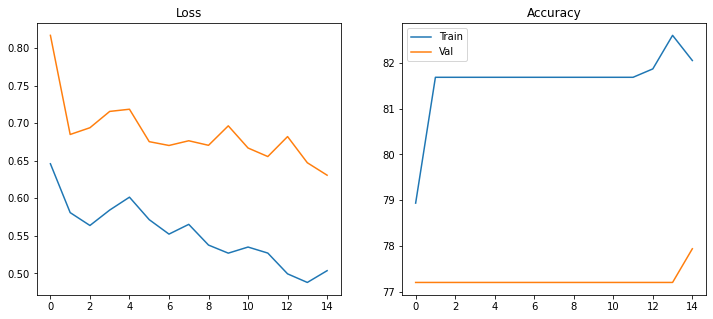

In [45]:
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
epochs = 15

for e in range(epochs):
    # --- Training ---
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    train_losses.append(total_loss/total)
    train_accs.append(correct/total*100)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            val_loss += loss.item()*x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_losses.append(val_loss/val_total)
    val_accs.append(val_correct/val_total*100)

    print(f"Epoch {e+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}% - "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")

# --- Plot ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(train_losses,label="Train"); plt.plot(val_losses,label="Val"); plt.title("Loss")
plt.subplot(1,2,2); plt.plot(train_accs,label="Train"); plt.plot(val_accs,label="Val"); plt.title("Accuracy")
plt.legend(); plt.show()


In [48]:
from torchvision import  models
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/lornaolum/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:42<00:00, 1.10MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
# Freeze the models weights
for params in model.parameters():
    params.requires_grad =False
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

in_features = model.fc.in_features

modified_last_layer = nn.Sequential()

dense_layer = nn.Linear(in_features, 256)
modified_last_layer.append(dense_layer)

relu = nn.ReLU()
modified_last_layer.append(relu)

modified_last_layer.append(nn.Dropout(p=0.5))

output_layer = nn.Linear(256, 3)
modified_last_layer.append(output_layer)

# Assign `modified_last_layer` to `model.fc`
model.fc = modified_last_layer

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
g = torch.Generator()
g.manual_seed(42)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [53]:
import torch

train_losses, val_losses, train_accs, val_accs = [], [], [], []
epochs = 10
model.train()

for e in range(epochs):
    # --- Training ---
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    train_losses.append(total_loss/total)
    train_accs.append(correct/total*100)
    
    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            val_loss += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_losses.append(val_loss/val_total)
    val_accs.append(val_correct/val_total*100)
    
    print(f"Epoch {e+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}% - "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}%")
    
    model.train()  # back to training mode


Epoch 1/10 - Train Loss: 0.6174, Train Acc: 78.21% - Val Loss: 0.6502, Val Acc: 77.21%
Epoch 2/10 - Train Loss: 0.5219, Train Acc: 83.52% - Val Loss: 0.5795, Val Acc: 78.68%
Epoch 3/10 - Train Loss: 0.4675, Train Acc: 83.70% - Val Loss: 0.5488, Val Acc: 83.09%
Epoch 4/10 - Train Loss: 0.4402, Train Acc: 86.63% - Val Loss: 0.6128, Val Acc: 77.21%
Epoch 5/10 - Train Loss: 0.4264, Train Acc: 84.98% - Val Loss: 0.6689, Val Acc: 78.68%
Epoch 6/10 - Train Loss: 0.4020, Train Acc: 87.73% - Val Loss: 0.4915, Val Acc: 84.56%
Epoch 7/10 - Train Loss: 0.3593, Train Acc: 87.73% - Val Loss: 0.5344, Val Acc: 80.15%
Epoch 8/10 - Train Loss: 0.3705, Train Acc: 87.18% - Val Loss: 0.4644, Val Acc: 84.56%
Epoch 9/10 - Train Loss: 0.3170, Train Acc: 89.01% - Val Loss: 0.5032, Val Acc: 85.29%
Epoch 10/10 - Train Loss: 0.3112, Train Acc: 89.19% - Val Loss: 0.5358, Val Acc: 85.29%


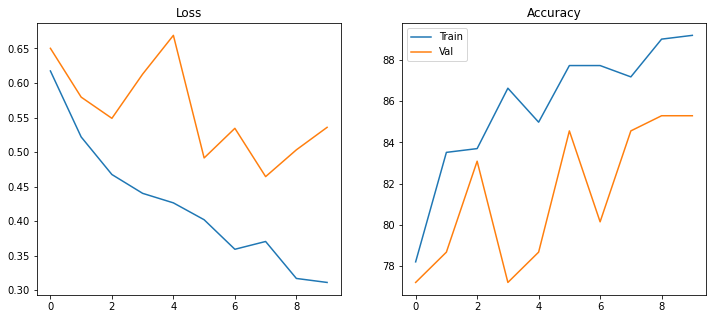

In [54]:
# --- Plot ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(train_losses,label="Train"); plt.plot(val_losses,label="Val"); plt.title("Loss")
plt.subplot(1,2,2); plt.plot(train_accs,label="Train"); plt.plot(val_accs,label="Val"); plt.title("Accuracy")
plt.legend(); plt.show()

In [61]:
import os

test_images = os.path.join(base, "test", "images")
print(os.listdir(train_images))

['mask_weared_incorrect', 'with_mask', 'without_mask']


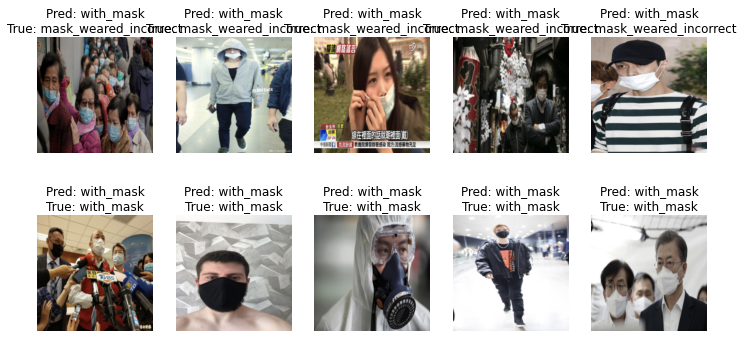

In [62]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- 1. Define test dataset ---
test_dir = os.path.join("data", "test")  # your test folder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(root=test_images, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

classes = test_dataset.classes
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# --- 2. Predict and visualize first 10 test images ---
plt.figure(figsize=(12,6))
for i, (images, labels) in enumerate(test_loader):
    if i == 10:  # show only first 10 images
        break
    
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    img = images[0].cpu().permute(1,2,0).numpy()
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {classes[predicted.item()]}\nTrue: {classes[labels.item()]}")
    
plt.show()


In [63]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 91.86%


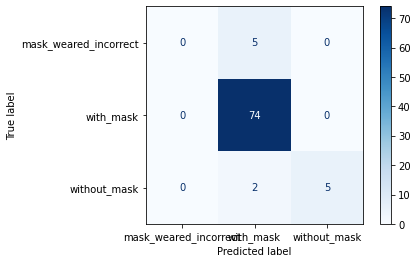

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [66]:
import cv2
import torch
from torchvision import transforms

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# Transformation (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

classes = ["with_mask", "without_mask", "mask_weared_incorrect"]


In [74]:
import time
import cv2
from PIL import Image
import torch
from torchvision import transforms

# Device and model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# Open webcam
cap = cv2.VideoCapture(0)

# Stop after 15 seconds
start_time = time.time()
duration = 15  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to PIL and apply transforms
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    img_t = transform(img_pil).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)
        label = classes[pred.item()]

    # Display label
    cv2.putText(frame, label, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Face Mask Detection", frame)

    # Check if 15 seconds have passed
    if time.time() - start_time > duration:
        break

    # Optional: still allow manual quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
